In [2]:
#Feature Selection:
#Feature Selection is one of the core concepts in machine learning which hugely impacts the performance of your model.
#The data features that we use to train your machine learning models have a huge influence on the performance we can achieve.

#Irrelevant or partially relevant features can negatively impact model performance.

#Benefits of performing feature selection:
#Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise(irrelevant data).
#Improves Performance: Less misleading data means model's performance improves.
#Reduces Training Time: Less data means that algorithms train faster.
#Out of the numerous feature selection techniques, I'll be discussing 4 here.

#Recursive Feature Elimination (RFE)
#Feature Importance using Random Forest
#Boruta
#XGBoost

In [3]:
# Note:
#The above mentioned techniques can be applied for both regression and classification problems. 
#Coming to this notebook I will be applying those techniques on a classification problem

In [5]:
# Import Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ignoring warnigs:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Load the data set:
col_names = ['preg', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedi', 'age', 'class']
data = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/pima-indians-diabetes.csv", names=col_names)
# names=col_names assigns the given names to the DataFrame columns (just to make the names shorter)

In [7]:
data.head()

,preg,glucose,bp,skin,insulin,bmi,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   preg     768 non-null    int64  
 1   glucose  768 non-null    int64  
 2   bp       768 non-null    int64  
 3   skin     768 non-null    int64  
 4   insulin  768 non-null    int64  
 5   bmi      768 non-null    float64
 6   pedi     768 non-null    float64
 7   age      768 non-null    int64  
 8   class    768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


<Axes: >

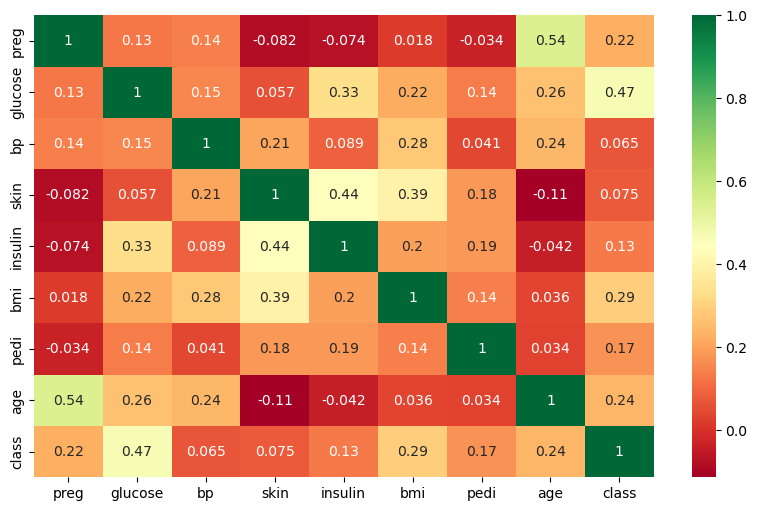

In [9]:
# Correlation matrix with heatmap:
# Get correlations of each features in dataset:
corrmat = data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corrmat, annot=True, cmap='RdYlGn')

In [10]:
#We can see from an initial analysis of the heatmap that glucose, bmi, age, preg, pedi and insulin 
#are the top 6 features that have relatively high correlation(positive) with class(our target variable). 
#It means that as they increase, diabetes of the patient also increases.

#Also, age and preg are highly correlated with each other.

In [11]:
# Splitting data into Input and Output Variable:
X = data.drop(['class'], axis=1)   # Input Variable
y = data[['class']]    # Output variable

In [12]:
# Split into train and test sets:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [13]:
#Basic Steps:
#The steps that we'll follow will look like:

#Train a baseline classifier ( any classifier like logistic regression or random forest trained with all the features in dataset)
#Identify the most important features using a feature selection technique
#Create a new ‘limited features’ dataset containing only those features
#Train a second classifier on this new dataset
#Compare the accuracy of the ‘full featured’(baseline) classifier to the accuracy of the ‘limited featured’(new) classifier

In [14]:
# Now let's implement various fearure selection techniques:
# 1) Recursive Feature Elimination (RFE):

#Recursive = Something that happens repeatedly

#As the name suggests, Recursive Feature Elimination works by recursively(repeatedly) removing features and building a model on the features that remain.

In [15]:
# Train a Logistic Regression Model (Baseline MOdel)
# This is the basic Logistic Regression model I'll use to check if the first feature selection technique make any improvements.

# Building the logistic Regression MOdel:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state=1)
lr_baseline_model = clf_lr.fit(X_train, y_train)

In [16]:
# Noting down accuracy of the baseline model:
from sklearn.metrics import accuracy_score, f1_score

# Finding our predictive values:
y_pred = lr_baseline_model.predict(X_test)

# Calculating the accuracy and f1 score by comparing the actual and predictive values:
ac = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)

print("Baseline Model Accuracy:", ac)
print("Baseline Model F1 Score:", f1_score)

Baseline Model Accuracy: 0.7795275590551181
Baseline Model F1 Score: 0.6455696202531646


In [17]:
# Applying RFE:
from sklearn.feature_selection import RFE

rfe = RFE(estimator = clf_lr, step=1)

fit = rfe.fit(X_train, y_train)

print("Num Features: %d", fit.n_features_)
print("Selected Features: %s", fit.support_)
print("Feature Ranking: %s", fit.ranking_)

Num Features: %d 4
Selected Features: %s [ True  True False False False  True  True False]
Feature Ranking: %s [1 1 3 4 5 1 1 2]


In [18]:
# Representing feature ranks in the form of a table:
selected_rfe_features = pd.DataFrame({'Feature': list(X_train.columns),
                                     'Ranking': rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
0,preg,1
1,glucose,1
5,bmi,1
6,pedi,1
7,age,2
2,bp,3
3,skin,4
4,insulin,5


In [19]:
# We can see that RFE gives preg, glucose, bmi, and pedi in the first rank.

In [20]:
# Create a new subset of the data with only the selected features:
# Now that I have obtained which features have the best score, I'll select only those features to fit the model.

In [21]:
# Transforming the data;
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fitting our baseline model with the transformed data:
lr_rfe_model = clf_lr.fit(X_train_rfe, y_train)

In [27]:
from sklearn.metrics import accuracy_score, f1_score

# Comparing of model performance with and without feaure selection:

# Making Prediction and evaluating the model:
y_pred_rfe = lr_rfe_model.predict(X_test_rfe)

rfe_ac = accuracy_score(y_test, y_pred_rfe)
rfe_fscore = f1_score(y_test, y_pred_rfe)

print("RFE Model Accuracy:", rfe_ac)
print("RFE Model F1 Score:", rfe_fscore)

RFE Model Accuracy: 0.7795275590551181
RFE Model F1 Score: 0.6410256410256411


In [28]:
# We can see an improvement in both accuracy and F1 score as oppose the baseline model(clf_lr) where I din't apply feature selection.

In [29]:
# Feature Importance using Random Forest:
#Feature importance is another feature selection technique used to select features. It gives you a score for each feature of your data, 
#the higher the score more important or relevant is the feature towards your output variable.

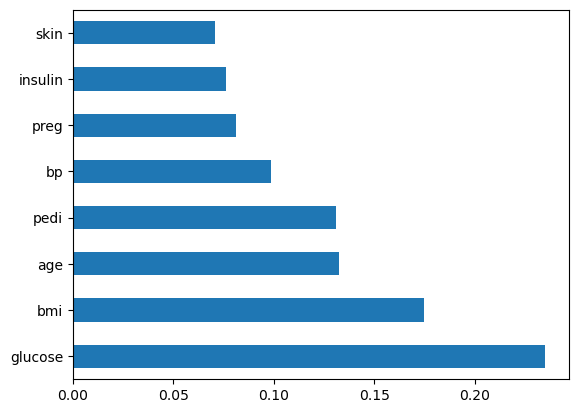

In [31]:
# Train a Random Forest Classifier (BaseLine Model)

from sklearn.ensemble import RandomForestClassifier
# Create a random forest classifier
rf_clf = RandomForestClassifier(n_estimators=10000, random_state=1, n_jobs=-1)
# n_estimators = The number of trees in the forest
# n_jobs = -1 : Use all processors for training

# Train the classifier
rf_clf.fit(X_train, y_train)

# Plot graph for feature importance for better visualization
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [32]:
#The scores above are the importance scores for each variable. There are two things to note. First, all the importance scores add up to 100%.

#Second, glucose, bmi, age, pedi are the top 4 features. The individual score of each is above 0.13.
#When combined, these 4 features have an importance of around 67.8%.

In [34]:
# Indentify and Select MOst Important Features:
from sklearn.feature_selection import SelectFromModel
# Create a selector object that will use the random forest classifer to identify
# It will select the features based on the importance score
rf_sfm = SelectFromModel(rf_clf)

# Train the selector:
rf_sfm = rf_sfm.fit(X_train, y_train)

In [35]:
# Create a new subset of the data with only the selected features:
# Transform the data to create a new dataset containing only the most important features:

X_important_train = rf_sfm.transform(X_train)
X_important_test = rf_sfm.transform(X_test)

In [36]:
# Train a new Random Forest Classifier using selected important features:

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=10000, random_state=1, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important = clf_important.fit(X_important_train, y_train)

In [37]:
# Comparison of model performance with and without feature selection:
y_pred = rf_clf.predict(X_test)
rf_ac = accuracy_score(y_test, y_pred)
rf_fscore = f1_score(y_test, y_pred)

# View the accuracy of our Full feature (8 features) model:
print("Baseline Model Accuracy:", rf_ac)
print("Baseline Model F1 Score:", rf_fscore)

Baseline Model Accuracy: 0.7913385826771654
Baseline Model F1 Score: 0.6666666666666666


In [38]:
#As can be seen by the above metrics, the accuracy and F1 Score of our original model which contained all eight 
#features and ‘limited’ model which contained only two features is almost the same. 
#We have halved the number of features in the model without changing the accuracy much, which is great!

In [39]:
# Boruta: Boruta is an all-relevant feature selection method. Unlike other techniques that select small set of features to minimize the error,
#Boruta tries to capture all the important and interesting features

In [41]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

In [42]:
# Train a Random Forest Classifier (Baseline Model)

from boruta import BorutaPy

# Define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=1)

forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=1)

In [43]:
# Apply the full Featured Classifier to the test data:
y_pred = forest.predict(X_test)
ac = accuracy_score(y_test, y_pred)
fscore = f1_score(y_test, y_pred)

# View the accuracy score of our full feature (8 features) model
print("Baseline Model Accuracy:", ac)
print("Baseline Model F1 Score:", fscore)

Baseline Model Accuracy: 0.7834645669291339
Baseline Model F1 Score: 0.6451612903225806


In [47]:
# Applying Boruta use Numpy array for computation and other benefits:

# By Deepseek:

# Corrected BorutaPy initialization
boruta_selector = BorutaPy(
    forest, 
    n_estimators='auto', 
    verbose=2, 
    random_state=42  # or random_state=None for non-reproducible randomness
)

# Fit Boruta
boruta_selector.fit(np.array(X_train), np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	1
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	1
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	1
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	1
Iteration: 	17 / 

BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=69,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1F942CEBC40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1F942CEBC40, verbose=2)

In [48]:
# As I saw above, Boruta categorises features into 3 categories - Confirmed, Tentative and Rejected.

# The features in the Tentative category are worked upon and put into one of Confirmed or Rejected. 
# The Confirmed category features are said to be the significant/important features.

In [49]:
# Check selected fearures:
print("Selected Features:", boruta_selector.support_)

# Check ranking of the features:
print("Ranking:", boruta_selector.ranking_)

print("No. of Significant Features: ", boruta_selector.n_features_)

Selected Features: [False  True False False  True  True  True  True]
Ranking: [2 1 3 4 1 1 1 1]
No. of Significant Features:  5


In [50]:
# Let's visualize it better in the form of a table
selected_rfe_features = pd.DataFrame({'Feature': list(X_train.columns),
                                     'Ranking':boruta_selector.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
1,glucose,1
4,insulin,1
5,bmi,1
6,pedi,1
7,age,1
0,preg,2
2,bp,3
3,skin,4


In [51]:
# Our model gave glucose, insuline, bmi, pedi, and age the first rank;

# Create a new subset of the data with only the selected features:
# Let's create a dataset with only these 5 feature now:

X_important_train = boruta_selector.transform(np.array(X_train))
X_important_test = boruta_selector.transform(np.array(X_test))

In [52]:
# Create a new random forest classifier for the  most important features
rf_important = RandomForestClassifier(n_estimators=10000, random_state=1, n_jobs=-1)

# Train the new classifier on the new dataset containing the most imptant features
rf_important.fit(X_important_train, y_train)

RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=1)

In [53]:
# Comparison of the model performance with and without feature selection:

# Apply the limited featured Classifier to the test data:
y_important_pred = rf_important.predict(X_important_test)

# View the accuracy pf our limited feature (4 features) model
rf_imp_ac = accuracy_score(y_test, y_important_pred)
rf_imp_fscore = f1_score(y_test, y_important_pred)

print("Limited Features Boruta MOdel Accuracy:", rf_imp_ac)
print("Limited Features Boruta Model F1 Score:", rf_imp_fscore)

Limited Features Boruta MOdel Accuracy: 0.7755905511811023
Limited Features Boruta Model F1 Score: 0.6586826347305389


Feature Importances: [0.08854468 0.23245336 0.0809117  0.09513386 0.10881558 0.15797086
 0.09442383 0.14174606]


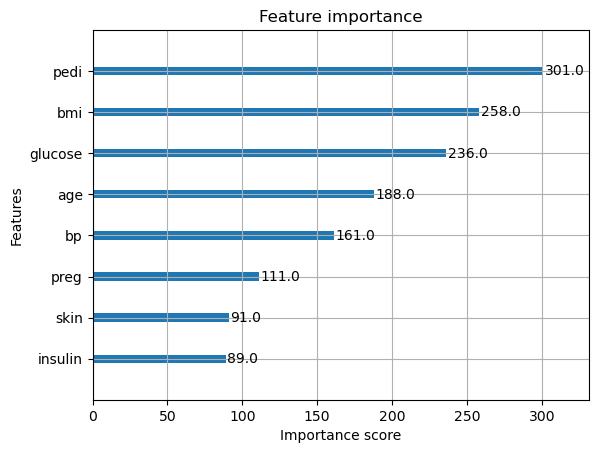

In [58]:
# XGBoost: Xgboost is short for eXtreme Gradient Boosting package.

# Train a XGBoost Classifier (Baseline Model)
from xgboost import XGBClassifier
from xgboost import plot_importance

# Fit the model to training data:
xgb_model = XGBClassifier(random_state=0)
xgb_model.fit(X_train, y_train)

print("Feature Importances:", xgb_model.feature_importances_)

# Plot feature importance:
plot_importance(xgb_model)
plt.show()

In [59]:
# XGBoost tells us that pedi, glucose, bmi and age are the top 4 features.

In [60]:
selection = SelectFromModel(xgb_model)
selection.fit(X_train, y_train)

# Transform the train and test features:
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

# Train model:
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [61]:
y_pred = xgb_model.predict(X_test)

xgb_ac = accuracy_score(y_test, y_pred)
xgb_fscore = f1_score(y_test, y_pred)

print("XGB Baseline Model Accuracy:", xgb_ac)
print("XGB Baseline Model F1 Score:", xgb_fscore)

XGB Baseline Model Accuracy: 0.7755905511811023
XGB Baseline Model F1 Score: 0.6742857142857143


In [62]:
# Evaluating the model:
predictions = selection_model.predict(select_X_test)   # Predict for selected features of X_test

xgb_accuracy = accuracy_score(y_test, predictions)   # Calculating accuracy score on test data

xgb_fscore = f1_score(y_test, predictions)    # Calculating F1 score on the test data


# View the accuracy score of our Limited Features (4 features) model:
print("Limited Features XGBoost Model Accuracy:", xgb_accuracy)
print("Limited Features XGB Model F1 Score:", xgb_fscore)

Limited Features XGBoost Model Accuracy: 0.7480314960629921
Limited Features XGB Model F1 Score: 0.6444444444444445


In [63]:
# XGBoost was able to achieve a petty good accuracy and F1 Score.

In [64]:
#Conclusion:
#We started with observing the heatmap of our data and derived glucose, bmi, age, preg, pedi and insulin to be the top 6 positively correlated features.
#We first trained our baseline Logistic Regression model using all the features.
#On implementing the Recursive Feature Elimination technique(claimed preg, glucose, bmi, pedi as top 4 features) 
#on Logistic Regression model, we observed significant change in both the metrics.
#Feature Importance technique using RandomForestClassifier stated that glucose, age, bmi, pedi and preg are 
#the most important features of our dataset. Using this, we were able to half the number of features in the model without changing the accuracy.
#Boruta didn't improve the performance much but was able to reduce the number of features to 5.
#XGBoost gave us good results overall.
#After implementing the 4 techniques, we can see that all of them gave us similar set of important features.